In [92]:
import os
import cv2
import matplotlib.pyplot as plt
from os.path import join, basename
import numpy as np
from collections import deque

In [60]:
def plot_img(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')

In [61]:
resize_h, resize_w = 540, 960

test_img_dir = os.path.join(os.getcwd(), 'data/test_images')
test_images = []
for img in os.listdir(test_img_dir):
    test_images.append(os.path.join(test_img_dir, img))
len(test_images)

6

In [108]:
class Line:
    def __init__(self, x1, y1,  x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.slope = self.calculate_slope()
        self.intercept = self.calculate_intercept()
    def calculate_slope(self):
        m = (self.y2 - self.y1) / (self.x2 - self.x1)
        return m
    def calculate_intercept(self):
        c = self.y2 - (self.slope*self.x2)
        return c
    def get_coordinates(self):
        return self.x1, self.y1, self.x2, self.y2

        
def region_of_interest(img, vertices):

    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image, mask

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    img = np.uint8(img)
    if len(img.shape) is 2:
        img = np.dstack((img, np.zeros_like(img), np.zeros_like(img)))

    return cv2.addWeighted(initial_img, α, img, β, λ)

def smoothen_over_time(lane_lines):

    avg_line_lt = np.zeros((len(lane_lines), 4))
    avg_line_rt = np.zeros((len(lane_lines), 4))

    for t in range(0, len(lane_lines)):
        avg_line_lt[t] += lane_lines[t][0].get_coordinates()
        avg_line_rt[t] += lane_lines[t][1].get_coordinates()

    return Line(*np.mean(avg_line_lt, axis=0)), Line(*np.mean(avg_line_rt, axis=0))

In [127]:
def get_lane_lines(lines):
    lines = [line for line in lines if 0.5 <= np.abs(line.slope) <= 2]
    pos_lines = [line for line in lines if line.slope > 0]
    neg_lines = [line for line in lines if line.slope < 0]
    
    neg_intercept = np.median([line.intercept for line in neg_lines]).astype(int)
    neg_slope = np.median([line.slope for line in neg_lines])
    x1, y1 = 0, neg_intercept
    x2, y2 = -np.int32(neg_intercept/neg_slope), 0
    left_lane = Line(x1, y1, x2, y2)
    
    
    pos_intercept = np.median([line.intercept for line in pos_lines]).astype(int)
    pos_slope = np.median([line.slope for line in pos_lines])
    x1, y1 = 0, pos_intercept
    x2, y2 = np.int32((resize_h - pos_intercept)/pos_slope), resize_h
    
    right_lane = Line(x1, y1, x2, y2)
    
    return(left_lane, right_lane)

def fun(image):
#     org_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    org_img = cv2.resize(image, (resize_w, resize_h))
    
    gray = cv2.cvtColor(org_img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (23, 23), 0)
    edge = cv2.Canny(blur, threshold1=50, threshold2=80)
    
    lines = cv2.HoughLinesP(edge, 2, np.pi/180, 1, np.array([]), 15, 5)
    
    lines = [Line(line[0][0], line[0][1], line[0][2], line[0][3]) for line in lines]
    
    lane_lines = get_lane_lines(lines)
    return lane_lines
    
    
def detect_lanes(frames):
    if len(frames) > 0:
        is_video = True
    else:
        is_video = False
    
    lane_lines = []
    for i in range(len(frames)):
        lane_lines.append(fun(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)))
    
    line_img = np.zeros(shape=(img.shape[0], img.shape[1]))
    
    lane_lines = smoothen_over_time(lane_lines)
    
    for lane_line in lane_lines:
#         print(lane_line.get_coordinates())
        x1, y1, x2, y2 = lane_line.get_coordinates()
        line_img = cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), [255,0,0], 10)

    vertices = np.array([[(50, img.shape[0]),
                          (450, 310),
                          (490, 310),
                          (img.shape[1] - 50, img.shape[0])]],
                        dtype=np.int32)

    img_masked, mask = region_of_interest(line_img, vertices)

    img_color = cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB)
    img_blend = weighted_img(img_masked, img_color, α=0.8, β=1., λ=0.)
    
    return img_blend

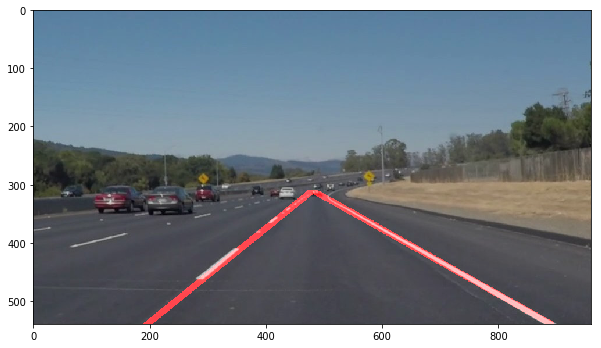

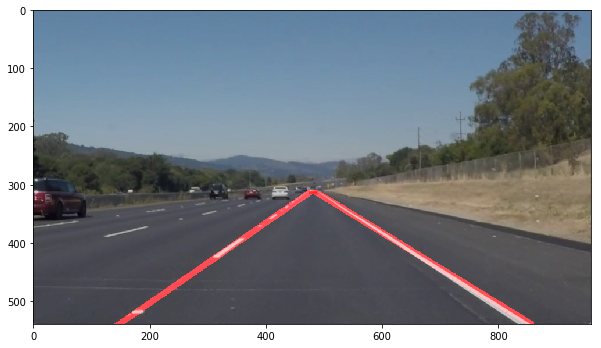

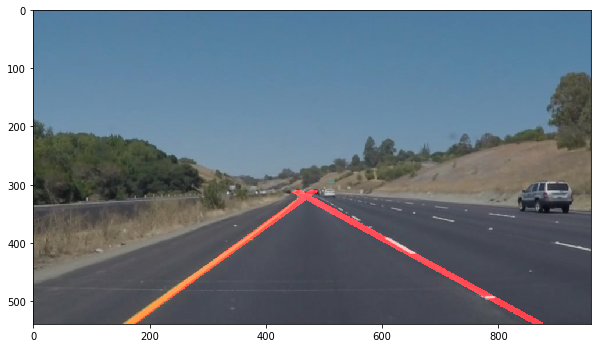

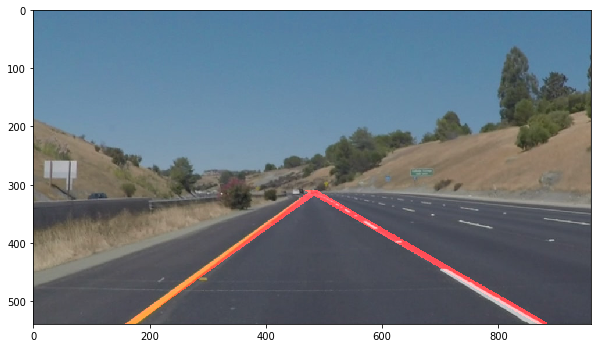

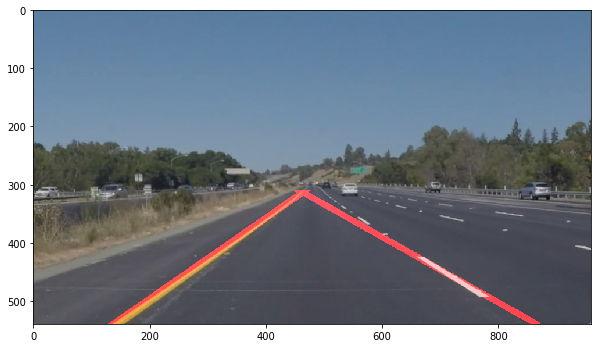

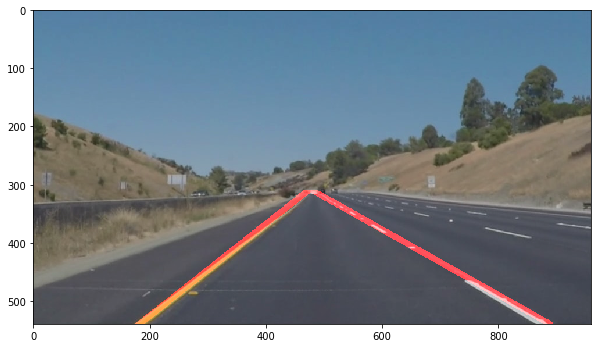

In [128]:
for test_img in test_images:
    img = cv2.imread(test_img)
    output = detect_lanes([img])
    plot_img(output)

In [129]:
resize_h, resize_w = 540, 960

video_dir = os.path.join(os.getcwd(), 'data/test_videos')
videos = []
for video in os.listdir(video_dir):
    videos.append(os.path.join(video_dir, video))
len(videos)

1

In [130]:
for video in videos:
    cap = cv2.VideoCapture(video)
    
    frame_buffer = deque(maxlen=10)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame_buffer.append(frame)
            out = detect_lanes(frame_buffer)
            cv2.imshow('out', out), cv2.waitKey(1)
        else:
            break
    cap.release()
    cv2.destroyAllWindows()

C:\Users\windo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in int_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\windo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\windo\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\windo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [139]:
class Line:
    def __init__(self, x1, y1,  x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.slope = self.calculate_slope()
        self.intercept = self.calculate_intercept()
    def calculate_slope(self):
        m = (self.y2 - self.y1) / (self.x2 - self.x1)
        return m
    def calculate_intercept(self):
        c = self.y2 - (self.slope*self.x2)
        return c
    def get_coordinates(self):
        return self.x1, self.y1, self.x2, self.y2

        


def region_of_interest(img, vertices):

    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image, mask

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    img = np.uint8(img)
    if len(img.shape) is 2:
        img = np.dstack((img, np.zeros_like(img), np.zeros_like(img)))

    return cv2.addWeighted(initial_img, α, img, β, λ)

(50, 80)
0 642 929 0
0 14 857 540


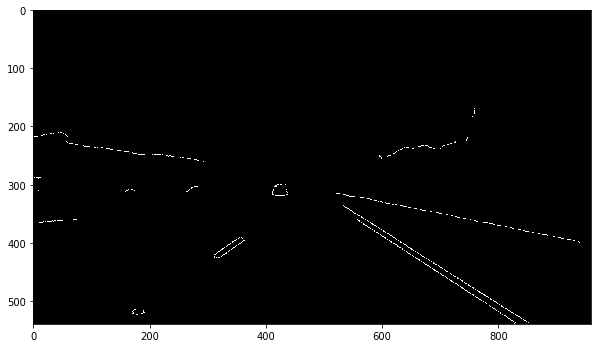

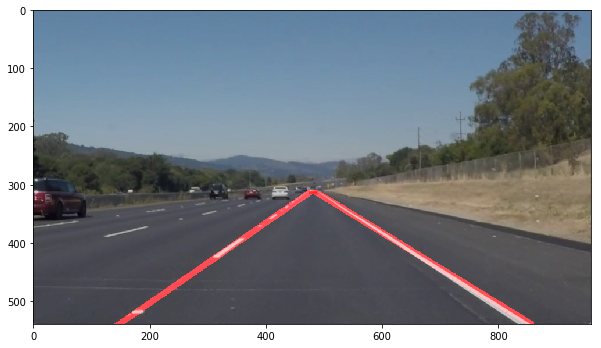

In [75]:
blurr = [(50, 80)]
for a in blurr:
    img = cv2.imread('data/test_images/solidWhiteRight.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plot_img(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # plot_img(gray)
    blur = cv2.GaussianBlur(gray, (23, 23), 0)
#     plot_img(blur)
    edge = cv2.Canny(blur, threshold1=a[0], threshold2=a[1])
    plot_img(edge)
    lines = cv2.HoughLinesP(edge,2,np.pi / 180,1,np.array([]),15,5)
    print(a)
    detected_lines = []
    for line in lines:
        detected_lines.append(Line(line[0][0], line[0][1], line[0][2], line[0][3]))
    # len(detected_lines)

    candidate_lines = []
    for line in detected_lines:
        if 0.5 <= np.abs(line.slope) <= 2:
            candidate_lines.append(line)
    # len(candidate_lines)

    pos_lines = [line for line in candidate_lines if line.slope > 0]
    neg_lines = [line for line in candidate_lines if line.slope < 0]

    # len(pos_lines), len(neg_lines)


    neg_intercept = np.median([line.intercept for line in neg_lines]).astype(int)
    neg_slope = np.median([line.slope for line in neg_lines])

    # print(neg_intercept, neg_slope)

    x1, y1 = 0, neg_intercept
    x2, y2 = -np.int32(neg_intercept/neg_slope), 0

    left_lane = Line(x1, y1, x2, y2)

    pos_intercept = np.median([line.intercept for line in pos_lines]).astype(int)
    pos_slope = np.median([line.slope for line in pos_lines])

    # print(pos_intercept, pos_slope)

    x1, y1 = 0, pos_intercept
    x2, y2 = np.int32((img.shape[0] - pos_intercept) / pos_slope), img.shape[0]

    right_lane = Line(x1, y1, x2, y2)


    line_img = np.zeros(shape=(img.shape[0], img.shape[1]))

    x1, y1, x2, y2 = left_lane.get_coordinates()
    print(x1, y1, x2, y2)
    line_img = cv2.line(line_img, (x1, y1), (x2, y2), [255,0,0], 10)

    x1, y1, x2, y2 = right_lane.get_coordinates()
    print(x1, y1, x2, y2)
    line_img = cv2.line(line_img, (x1, y1), (x2, y2), [255,0,0], 10)

    vertices = np.array([[(50, img.shape[0]),
                          (450, 310),
                          (490, 310),
                          (img.shape[1] - 50, img.shape[0])]],
                        dtype=np.int32)

    img_masked, mask = region_of_interest(line_img, vertices)

    img_color = img
    img_blend = weighted_img(img_masked, img_color, α=0.8, β=1., λ=0.)

    plot_img(img_blend)

In [7]:



# lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
#                             maxLineGap=max_line_gap)